In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.model.predictor_gru import GRUPredictor_mu
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

In [2]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [3]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
# df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
# df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
# df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [4]:
df_col = df_col[df_col['object'] != 'ground']

sim_data = data_utils.get_sim_data(df_ball, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 1)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_ball, df_env, df_col)
states, envs = data_utils.to_tensors(simulations, environments, device)

In [5]:
# print(selected_runs)
# print(df_ball)
# simulations.t.max()
# print(df_col[df_col['simulation'] == 'sim_1'])

# del df_ball, df_env, df_col

# print(states)
# print(states[0, :, 2])

In [23]:
def get_logp_loss(gm, targets, weight = None):
    logp_loss_all = -gm.log_p(targets)
#     print('logp_loss_all is \n', logp_loss_all[0])
#     print('logp_loss_all is in shape ', logp_loss_all.shape)
    
    if weight is not None:
        logp_loss_all_weight = logp_loss_all * weight
#         print(logp_loss_all_weight[0])
        return logp_loss_all_weight.mean()
    else:
        return logp_loss_all.mean()

def get_mu_mse_loss(gm, targets):
    return F.mse_loss(gm.mu[:,:,0], targets)



In [7]:
def get_collision_weight(collisions, ratio):

    collision_weights = torch.zeros(collisions.shape[0],collisions.shape[1], device = device)
    # print(collision_weights)
    
    for i in range(collisions.shape[0]):
        for j in range(collisions.shape[1] - 1, -1, -1):
            if collisions[i,j - 1] == 1:
    #             print(i, j)
                collisions[i,j] = 0
            else:
                break

    for i in range(collisions.shape[0]):
        for j in range(collisions.shape[1]):
            if collisions[i,j] == 0:
                if j < 5:
                    collision_weights[i,j] = ratio - j * (ratio/5)
                else:
                    if collision_weights[i,j] == 0:
                        collision_weights[i,j] = 1
            elif collisions[i,j] == 1:
                for k in range(5):
                    if (j + k) < collisions.shape[1]:
                        collision_weights[i,j + k] = ratio - k * (ratio/5)
#     print(collision_weights)
    
    return collision_weights



def get_collision_weight_fast(collisions, ratio):
    collisions[:, 0] = 1
    collision_weights = collisions * (ratio - 1) + 1
    
    return collision_weights

In [8]:
# model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
model = GRUPredictor_mu(env_size=11, state_size=2, num_gaussians=1, trainable_h0 = True).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# del envs, states

# print(dataloader)
# print(len(dataset))

# for batch_i, batch in enumerate(dataloader):
#     if batch_i == 0:
#         print(batch_i)
#         print(batch['states'][0])
#         print(batch['targets'][0])


In [24]:
max_t = simulations.t.max()
epochs = 1000
losses = []
mu_overtime = []
sigma_overtime = []
target_overtime = []
# for epoch in tqdm(range(epochs+1)):
for epoch in tqdm(range(101)):
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_logp_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
#         print('Batch ', batch_i)
        gm = model(batch['envs'], batch['states'][:, :, :2], 0)
        collisions = batch['states'][:, :, 2]
        collision_weights = get_collision_weight_fast(collisions, ratio = 50)
        targets = batch['targets']
        
#         logp_loss = get_logp_loss(gm, targets)        
#         print('logp_loss is ', logp_loss)
        logp_loss = get_logp_loss(gm, targets, collision_weights)
#         print('logp_loss_weight is ', logp_loss)
        mse_loss = 10*get_mu_mse_loss(gm, targets)
#         loss = logp_loss + mse_loss
        loss = logp_loss + mse_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_logp_loss += logp_loss
        epoch_mse_loss += mse_loss
        losses.append((epoch, batch_i, float(loss)))
        
        
        if batch_i == 0:
            gm_mu = gm.mu[:,:,0]
            target_mu = targets
            gm_sigma = gm.sigma[:,:,0]
        
    mu_overtime.append(gm_mu)
    sigma_overtime.append(gm_sigma)
    target_overtime.append(target_mu)    
    
    if epoch%1 == 0:
        print('Epoch {} | logp: {} | mse: {} | total: {}'.format(epoch,
                                                                 round(float(epoch_logp_loss), 4),
                                                                 round(float(epoch_mse_loss), 4),
                                                                 round(float(epoch_loss), 4)))
    
#     if (loss - prev_loss) < .1 and (loss - prev_loss) > -.1:
#         break
    
torch.save(model.state_dict(), 'gru.model')
torch.save(mu_overtime, 'mu_overtime.pt')
torch.save(sigma_overtime, 'sigma_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

logp_loss_all is 
 tensor([-6.7507, -6.0178, -5.9348, -6.4232, -6.3564, -6.1459, -5.9321, -5.7534,
        -5.6320, -5.5673, -5.5089, -5.3965, -5.2024, -4.9460, -4.6784, -2.0651,
        -3.8021, -4.0605, -4.4790, -4.6072, -4.6648, -4.7013, -4.7265, -4.7428,
        -4.7527, -4.7579, -4.7599, -4.7594, -4.7569, -4.7530, -4.7481, -4.7424,
        -4.6582, -4.2938, -4.6539, -4.7797, -4.8090, -4.8180, -4.8194, -4.8127,
        -4.7993, -4.7813, -4.7610, -4.7403, -4.7211, -4.7047, -4.6919, -4.6827,
        -4.6764, -4.6721, -4.6679, -4.6622, -4.6538, -4.6417, -4.6259, -4.6068,
        -4.5858, -4.5647, -4.5457, -4.5311, -4.5227, -4.5225, -4.5317, -4.5513,
        -4.5810, -4.6183, -4.6563, -4.6781, -4.6442, -4.4664, -3.9677,  0.1828,
        -4.1242, -5.4091, -5.3605, -5.2581, -5.2144, -5.2054, -5.1995],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-3.3754e+02, -6.0178e+00, -5.9348e+00, -6.4232e+00, -6.3564e+00,
        -6.1459e+00, -5.9321e+00, -5.7534e+00, -5.6320e+00, -5.567

RuntimeError: cudnn RNN backward can only be called in training mode

In [14]:
torch.save(model.state_dict(), 'gru.model')
torch.save(mu_overtime, 'mu_overtime.pt')
torch.save(sigma_overtime, 'sigma_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

In [9]:
mu_overtime = torch.load('mu_overtime.pt')
sigma_overtime = torch.load('sigma_overtime.pt')
target_overtime = torch.load('target_overtime.pt')
losses = torch.load('losses.pt')


# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('gru.model'))
model.eval()

GRUPredictor_mu(
  (env_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
    )
  )
  (state_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=16, bias=True)
    )
  )
  (gru): GRU(48, 128, num_layers=2)
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=6, bias=True)
    )
  )
)

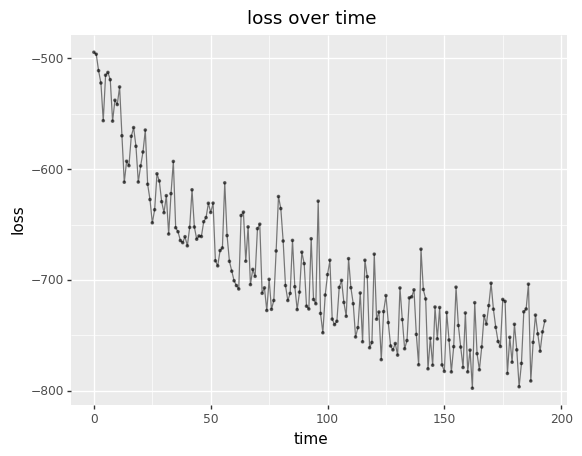

<ggplot: (8778986607161)>


In [10]:
# print(losses)
plinko_plot.plot_losses(losses)
# plinko_plot.plot_mu_over_time(mu_overtime)
# plinko_plot.plot_variance_over_time(sigma_overtime)

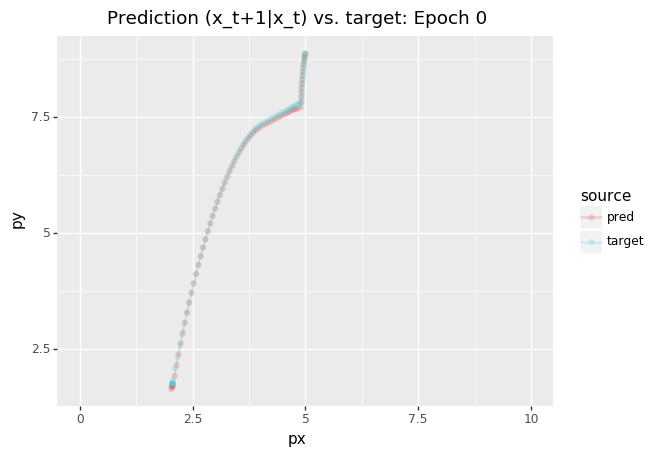

<ggplot: (8778898446181)>


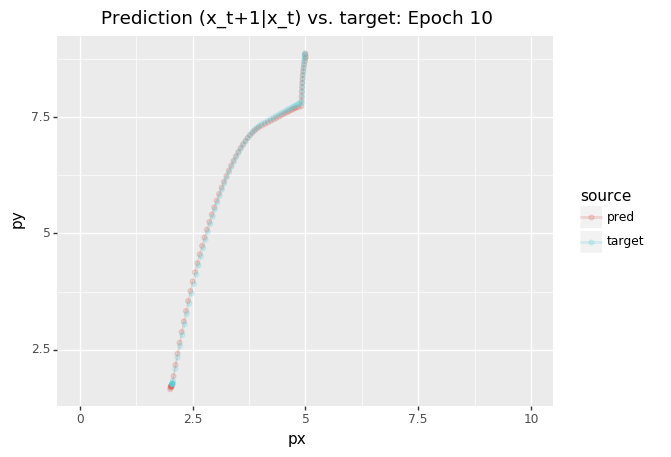

<ggplot: (8778986594897)>


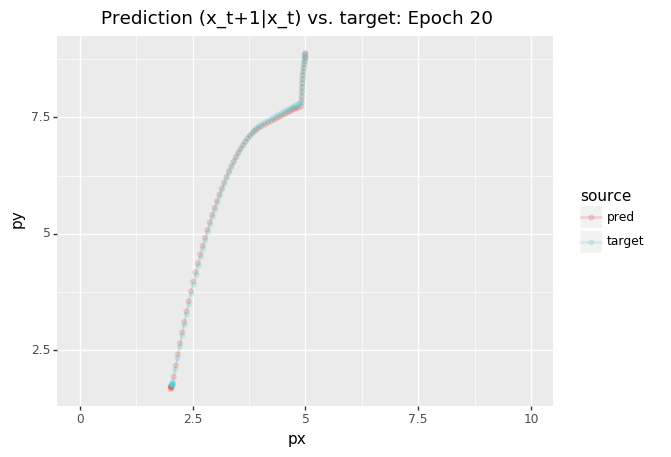

<ggplot: (8778898203829)>


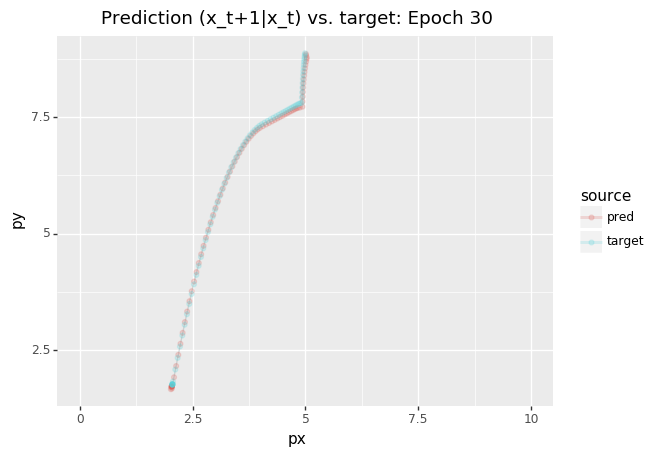

<ggplot: (8778906799593)>


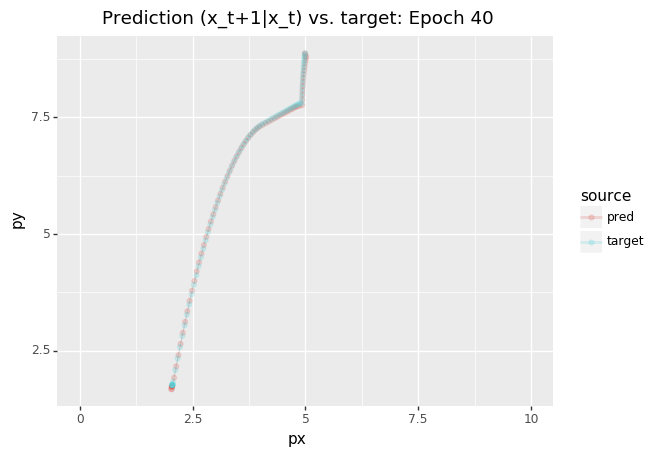

<ggplot: (8778898100857)>


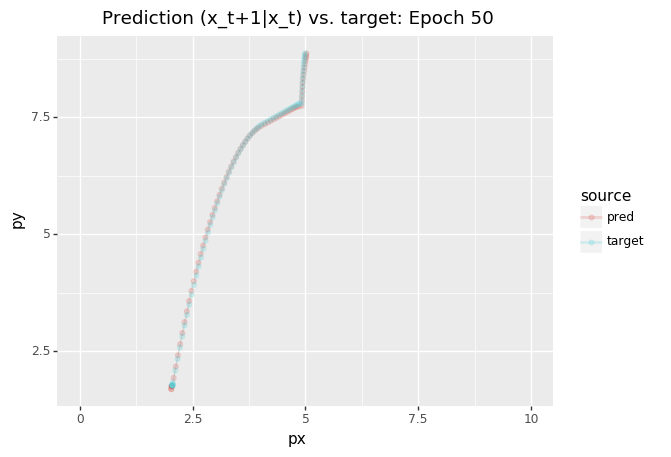

<ggplot: (8778898601701)>


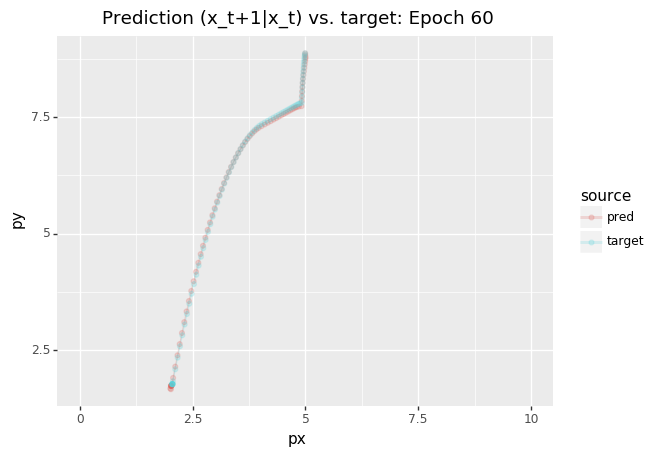

<ggplot: (8778898007793)>


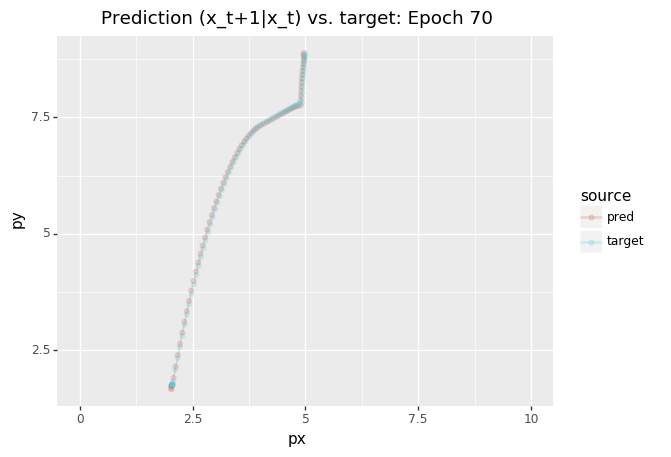

<ggplot: (8778897986009)>


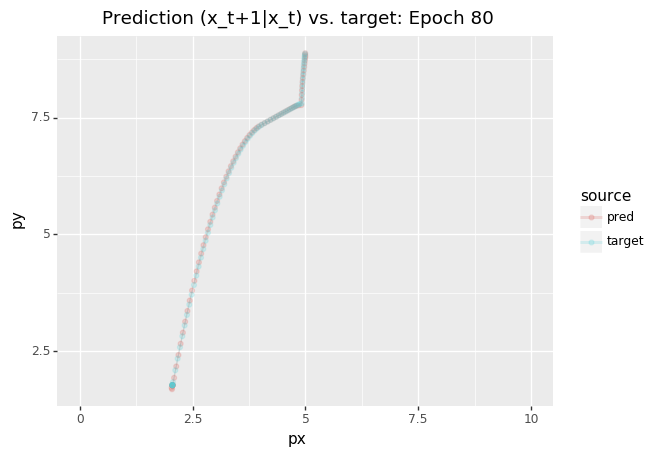

<ggplot: (8778897967697)>


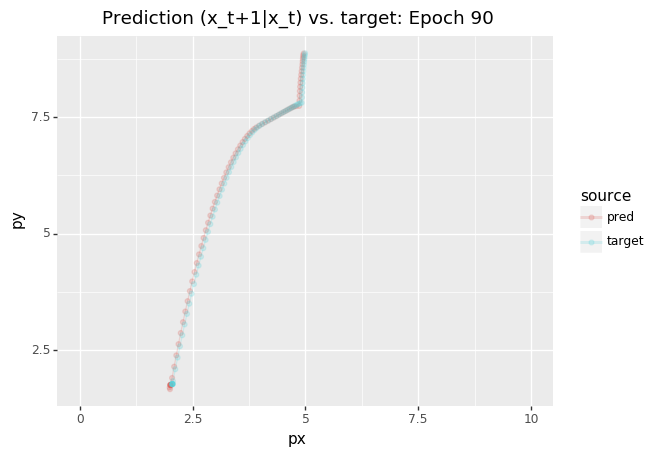

<ggplot: (8778897993461)>


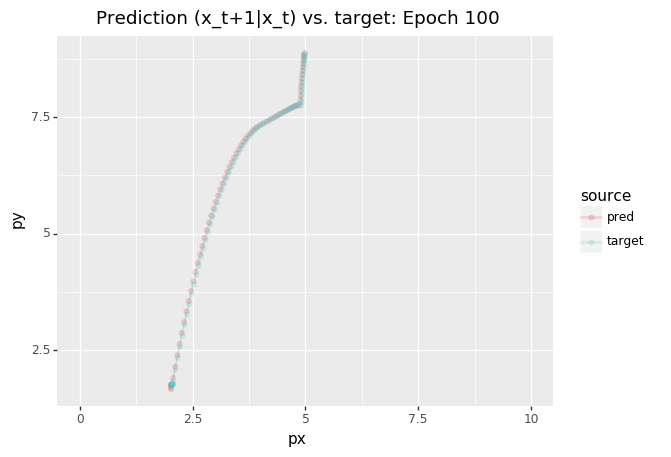

<ggplot: (8778896645257)>


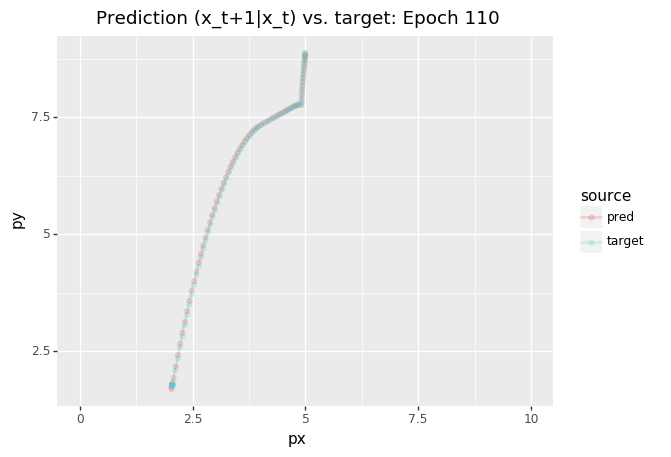

<ggplot: (8778896581737)>


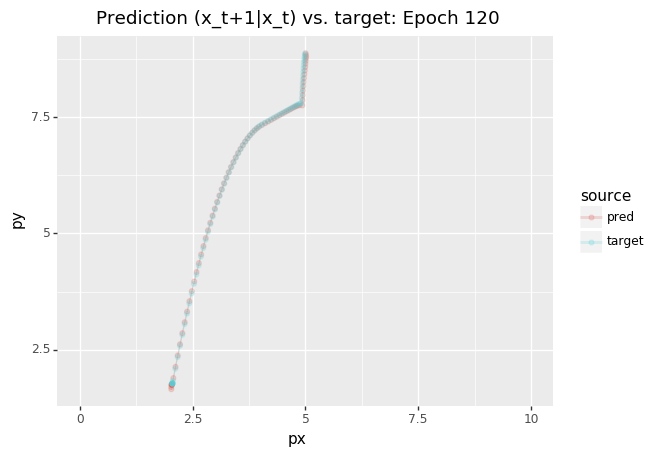

<ggplot: (8778898446641)>


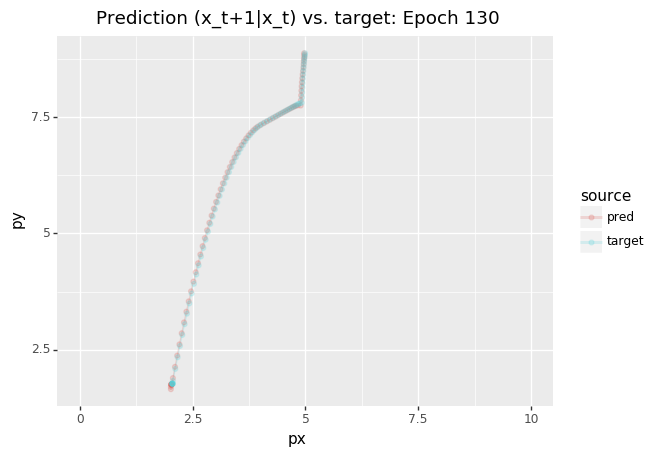

<ggplot: (8778898601617)>


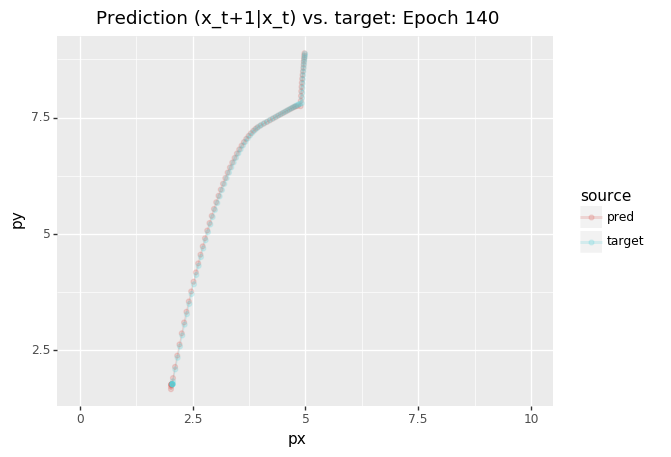

<ggplot: (8778898536417)>


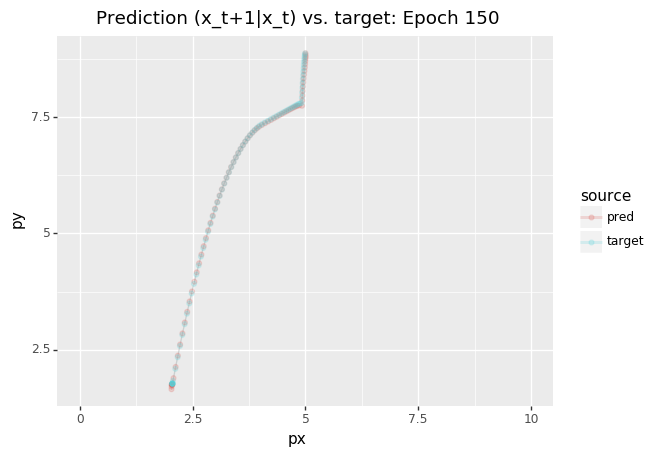

<ggplot: (8778898596533)>


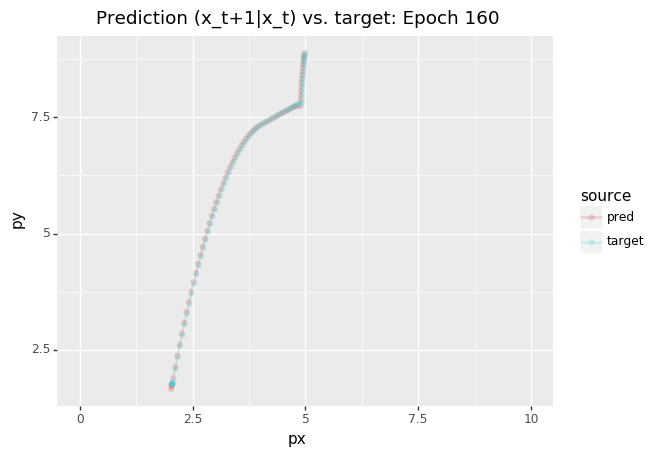

<ggplot: (8778898465733)>


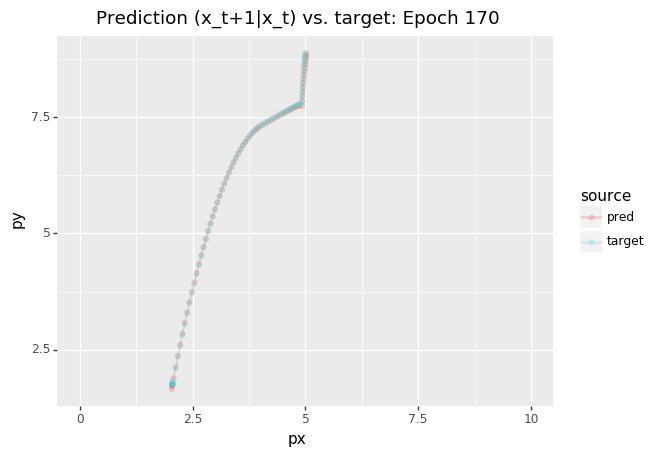

<ggplot: (8778898462689)>


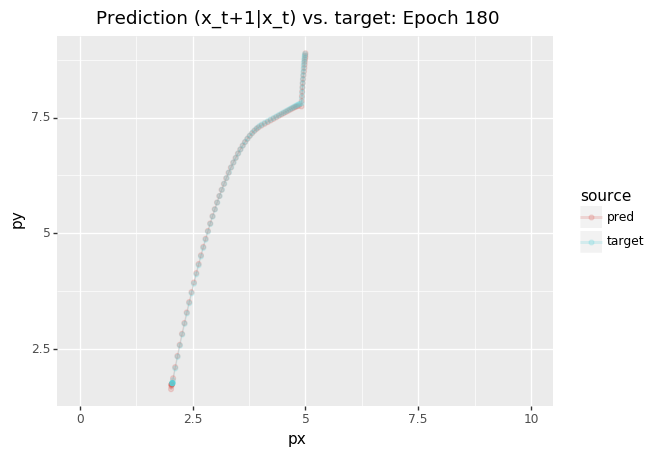

<ggplot: (8778898446445)>


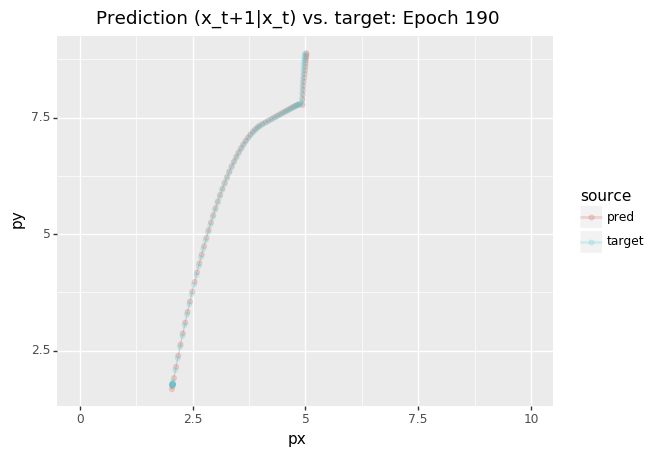

<ggplot: (8778898020037)>


In [17]:
for t in range(len(mu_overtime)):
    if t %10 == 0:
        plinko_plot.plot_pred_target(mu_overtime[t], target_overtime[t], sim_range = range(1),
                                    title = "Prediction (x_t+1|x_t) vs. target: Epoch {}".format(t))

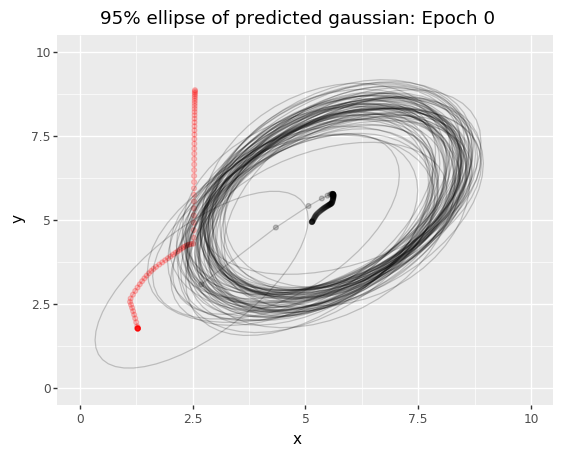

<ggplot: (8774053794989)>


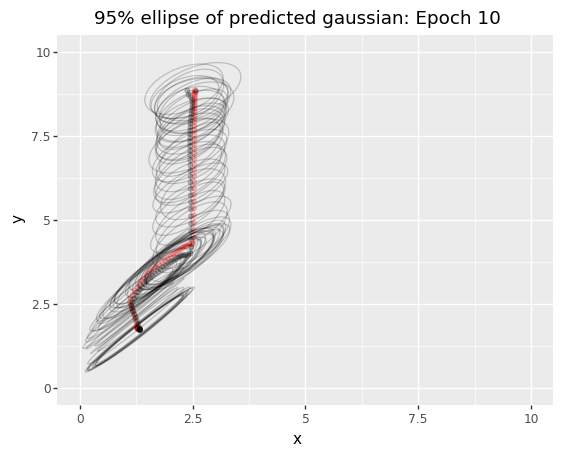

<ggplot: (8774053525137)>


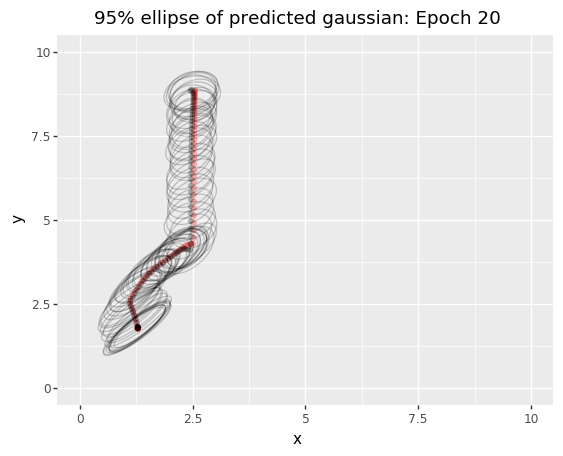

<ggplot: (8774052474149)>


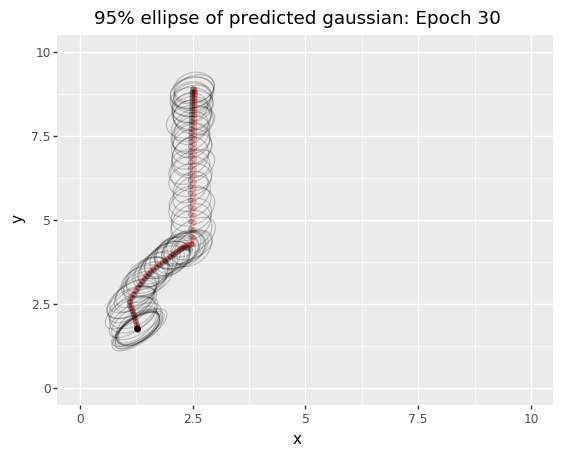

<ggplot: (8774053550069)>


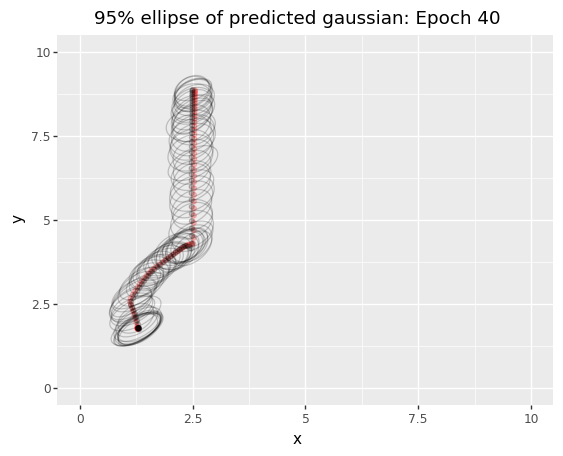

<ggplot: (8774053534221)>


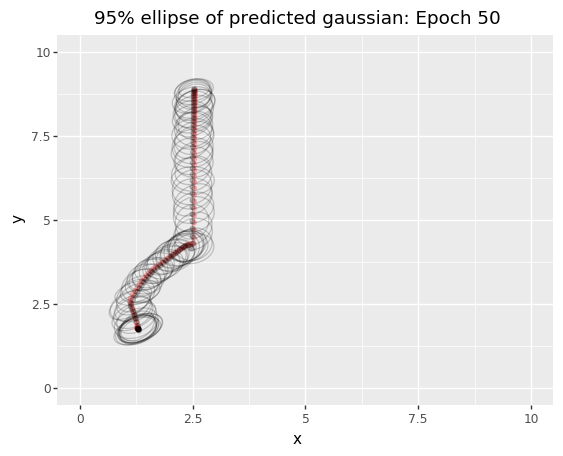

<ggplot: (8774053790253)>


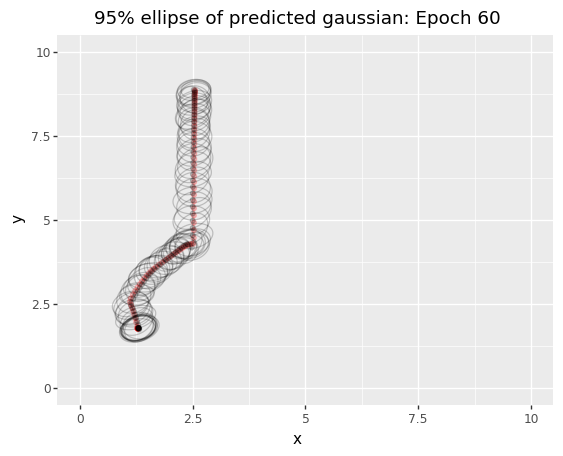

<ggplot: (8774053929625)>


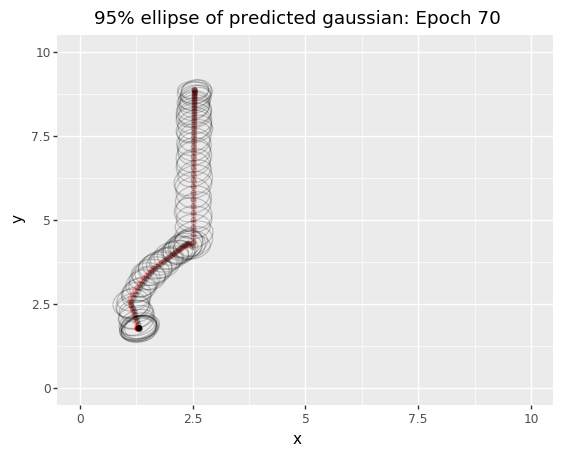

<ggplot: (8774053929625)>


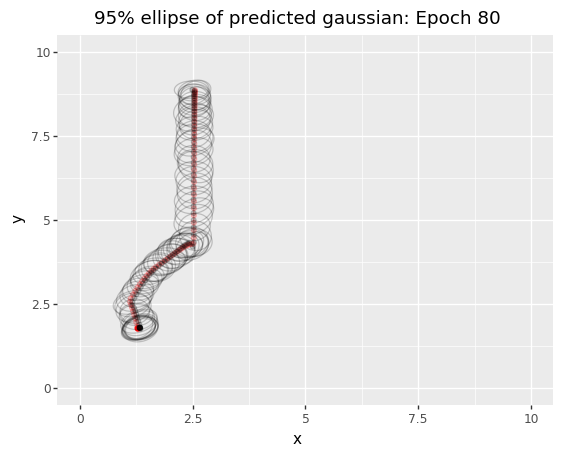

<ggplot: (8774060366069)>


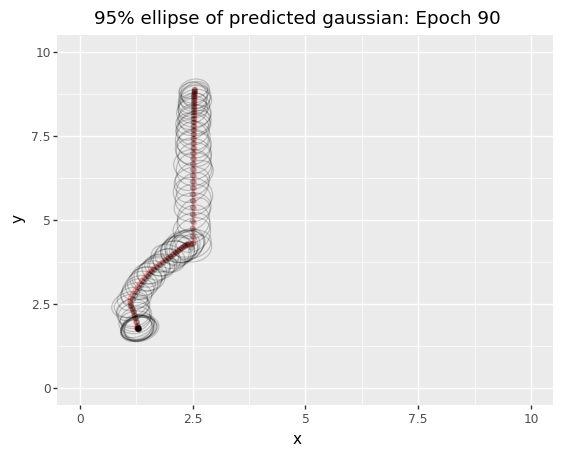

<ggplot: (8774060360137)>


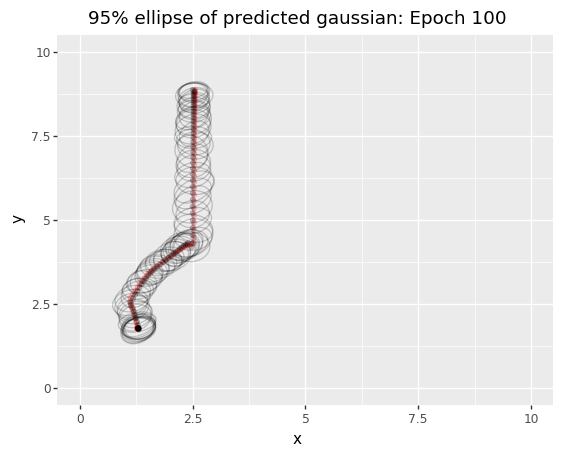

<ggplot: (8774053935517)>


In [13]:
# print(target_overtime[1])

for t in range(len(mu_overtime)):
    if t %10 == 0:
        plinko_plot.plot_pred_gaussian(mu_overtime[t], target_overtime[t], sigma_overtime[t], sim_index = 0, 
                                   title = "95% ellipse of predicted gaussian: Epoch {}".format(t), 
                                       color = 'red', alpha = .2)

In [11]:
def simulate_model(model, dataset, sim_t = 1):
    """
    :sim_t = how many time points to feed in for the simulation
    """
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
            inter_gm, extra_gm, samples = model(batch['envs'], batch['states'][:, 0:sim_t, :2], dataset[0]['states'].shape[0] - sim_t)
            targets = batch['targets'][:,1:101]
#             df_env, df_ball = data_utils.create_simdata_from_samples(samples, batch['envs'],sim_df, env_df)
            
            return samples, targets

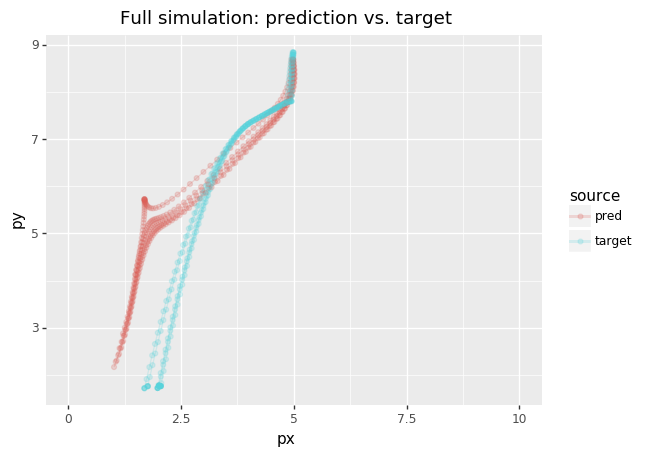

<ggplot: (8778898540785)>


In [22]:
# print(sim_samples.shape)
# print(sim_targets.shape)
# print(gm.mu.shape)

# print(dataset[0]['states'].shape[0])
# simulate from trained model
sim_samples, sim_targets = simulate_model(model, dataset, sim_t = 5)

plinko_plot.plot_pred_target(sim_samples, sim_targets, sim_range=range(5), 
                             title = "Full simulation: prediction vs. target")